# Massive Data Storage and Retrieval - Intermediate Report

### Project goals and why it is interesting

Recent advances in the field have shown that Reinforcement Learning agents are often capable of learning much more than supervised learning agents within the same problem domain. Moreover, the Bitcoin price history since it's inception shows that it has a very volatile value.  ML methods, reinforcement learning (RL) is particularly interesting, especially the Q-learning approach. First, Q-learning does not model the market, instead of focusing on the benefit (Q value) associated with actions. This avoids the errors caused by any market model. Second, Q-learning is suitable to do online learning, which enables quick adaptation to new market status. Third, Q-learning pays attention to long-term benefit rather than instantaneous reward, which is congruent with the goal of stock trading, maximizing long-term profit. Currently, reinforcement learning has been applied in financial analysis and investment by a multitude of researchers. 

In this project, we propose to employ Deep Q-learning to build an Algorithmic Cryptocurrency Trading system which can automatically determine what position to hold at each trading time. We apply the deep Q-learning approach where our goal is to build a deep Q-trading system that determines when to buy and sell, based on the current and historical market data.

### Source of Data

The historical bitcoin data is taken from the site 'https://www.investing.com/crypto/bitcoin/historical-data'.
It has 5 years (1st Jan 2014 - 31st Dec 2018) of bitcoin data

### Data Preprocessing & Cleaning

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import plotly.graph_objects as go
import pyspark
import urllib.request as urllib2

from pyspark.sql.session import SparkSession
from io import StringIO
%matplotlib inline

In [3]:
url = "http://www.sharecsv.com/dl/90e8a350aaebc4e180d5d2a6c7777214/bitcoin_data.csv"
response = urllib2.urlopen(url)
data = response.read()      
text = data.decode('utf-8')
data = spark.read.csv(sc.parallelize(text.splitlines()), header=True)
data = data.toPandas()

NameError: name 'spark' is not defined

In [107]:
# Removing the rows with NAN values in the data
data.dropna() #Removing rows with nan values

,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 31, 2018","3,709.4","3,815.1","3,819.6","3,658.8",545.83K,-2.77%
1,"Dec 30, 2018","3,815.0","3,708.2","3,837.7","3,682.5",519.17K,2.92%
2,"Dec 29, 2018","3,706.8","3,861.6","3,899.6","3,696.0",505.41K,-4.01%
3,"Dec 28, 2018","3,861.6","3,587.1","3,900.3","3,565.5",565.24K,7.66%
4,"Dec 27, 2018","3,586.9","3,793.4","3,822.6","3,560.8",543.44K,-5.45%
...,...,...,...,...,...,...,...
1821,"Jan 05, 2014","1,014.7",924.7,"1,029.9",911.4,21.37K,9.74%
1822,"Jan 04, 2014",924.7,884.3,932.2,848.3,14.24K,4.57%
1823,"Jan 03, 2014",884.3,856.9,888.2,839.4,9.71K,3.19%
1824,"Jan 02, 2014",856.9,815.9,886.2,810.5,12.81K,5.02%


#### Size of the data

In [108]:
data.shape

(1826, 7)

The above data set has 7 columns and 1826 rows.

#### Removing Duplicate Rows
The next data processing step would be to check if there are any duplicate rows in the date column

In [109]:
duplicateRows = data[data.duplicated(['Date'])]
print (duplicateRows)

Empty DataFrame
Columns: [Date, Price, Open, High, Low, Vol., Change %]
Index: []


This shows that the date column in the data does not have any duplicate values

#### Level of the Dataframe
Since there are no duplicates in the 'Date' column of the data.
The data is in the level of 'Date' column. The 'Date' column can be used as the primary key

#### Data types of each column

In [110]:
data.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In the data, the columns of 'Price','Open', 'High' and 'Low' are of the object type and numeric. This is because these columns use comma for separation of thousands. Hence we need to replace ',' with ''(Null) character and then convert it to numeric data type

In [111]:
data['Price'] = data['Price'].str.replace(',', '').astype(float)
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High'] = data['High'].str.replace(',', '').astype(float)
data['Low'] = data['Low'].str.replace(',', '').astype(float)

In [112]:
data['Date'] = data['Date'].astype('datetime64[ns]')

In [113]:
data['Change %'] = data['Change %'].str.replace('%', '').astype(float)

The 'Vol.' column in the data uses 'K' to denote thousands and 'M' to denote Millions. We will have to convert them to float data types. This can be done by identifying the rows with characters 'K' or 'M'. We replace the characters with Null character and convert the column to float. Now one again we determine the rows with characters 'K' and 'M' and replece it with 10**3 and 10**6 respectively, where ** denotes raising the value to its power.
Finally this rows with 'K' are multiplied by 10^3, rows with 'M' are multiplied by 10^6 and rows with 'K' and 'M' are multiplied by 1

In [114]:
data['Vol.'] = (data['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * data['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))

In [115]:
data.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.               float64
Change %           float64
dtype: object

In [116]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2018-12-31,3709.4,3815.1,3819.6,3658.8,545830.0,-2.77
1,2018-12-30,3815.0,3708.2,3837.7,3682.5,519170.0,2.92
2,2018-12-29,3706.8,3861.6,3899.6,3696.0,505410.0,-4.01
3,2018-12-28,3861.6,3587.1,3900.3,3565.5,565240.0,7.66
4,2018-12-27,3586.9,3793.4,3822.6,3560.8,543440.0,-5.45


In [117]:
data['Price'].idxmax()

380

In [118]:
data.iloc[94]


Date        2018-09-28 00:00:00
Price                      6636
Open                     6685.7
High                     6809.2
Low                      6538.6
Vol.                   9.57e+06
Change %                  -0.79
Name: 94, dtype: object

In [119]:
data['Vol.'].idxmax()

94

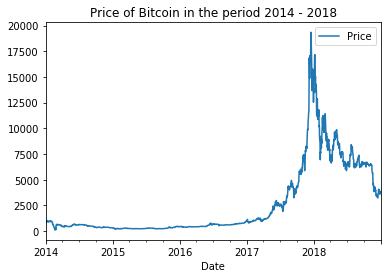

In [120]:
data.plot(x='Date', y=['Price'], kind='line', title='Price of Bitcoin in the period 2014 - 2018')

Text(0, 0.5, 'Volume-->')

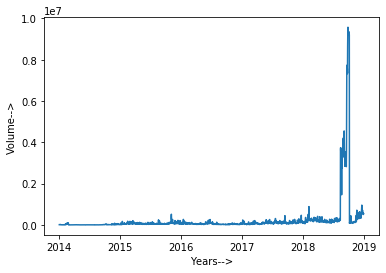

In [121]:
plt.plot(data['Date'],data['Vol.'])
plt.xlabel('Years-->')
plt.ylabel('Volume-->')

#### Candlestick chart 
It describes open, high, low and close for a given bitcoin price per day. The boxes represent the spread between the open and close values and the lines represent the spread between the low and high values. Sample points where the close value is higher (lower) then the open value are called increasing (decreasing). By default, increasing candles are drawn in green whereas decreasing are drawn in red.

In [122]:
fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Price'])])

fig.show()

### Ideas for the next phase

#### Architecture

We're planning to implement a Deep Q-network with 4 layers in total(two are hidden), with the number of units set to approximately 90, 100, 100, and 3 respectively.

**Input**: The input units were composed by the delta price (difference between two consecutive days) of the bitcoin price chart
**Output**: The output units correspond to the three actions in trading namely: Buy, Hold, and Sell.

#### Implementation overview

We will consider a simple trading task that operates on a single security, and at each trading day $t$, only one action will be allowed. The action at $a_{t}$ will have 3 options: hold, buy, or sell and a reward $r_{t}$ will be obtained. Our task will be to learn a deep Q-function $Q(s,a)$ that maximizes the long term accumulated profit. No transaction cost will be considered in this project.

The environment will mimic the OpenAI gym infrastructure. We intend to write our Artificial Neural Network in Keras. Pandas and Spark was used for data preprocessing and cleaning. Data visualization will be done using the matplotlib library and the model will be evaluated based on parameters like loss and reward generated during training.

### Acknowledgments

* http://cslt.riit.tsinghua.edu.cn/mediawiki/images/5/5f/Dtq.pdf